In [1]:
import numpy                as np
import matplotlib.pyplot    as plt
from astropy import units   as units
import datetime as dt
import sys
from pathlib            import Path
from matplotlib         import rcParams, rc
from scipy.interpolate  import interp1d
# Change the matplotlib default parameters
rcParams.update({'font.size':   8})
rcParams.update({'figure.dpi': 120})

sys.path.append('/lhome/silkem/ChemTorch/ChemTorch/')
from src.read               import read_data_chemtorch
# from src.rates          import *
from src.solve_n_save       import solve_dg
from src.input              import density

rate = 16

outloc = '/lhome/silkem/ChemTorch/ChemTorch/out/'

In [2]:
## Ranges from PHANTOM models
ρ_min = -1.
ρ_max = 1.
T_min = -1.
T_max = 5
δ_min = 1.e-6
δ_max = 1
Av_min = -1
Av_max = -np.log(δ_max)
dt_min = 3.8
dt_max = 5.

nstep = 512

In [3]:
### !!! HIER VERONDERSTELLEN WE ONGECORRELEERDE PARAMETERS


def fdens(x):
	return 1./(x+1.001)

def ftemp(x):
	return -1.05*np.log10(x+3)+1

def fdelta(x):
	return np.ones_like(x)

def fAv(x):
	return np.ones_like(x)

def fdt(x):
	return x**3./(-1.+np.exp(-x+3.8001))

## cummulative sum 
## generate random numbers between [0,1)
## Define a function to return N samples
def genSamples(xmin, xmax, nstep, N, f):
	xbin = np.linspace(xmin, xmax, nstep)
	ycum = np.cumsum(f(xbin))
	u = np.random.uniform(ycum.min(), ycum.max(), int(N))
    ## take the inverse of cumm. function
	func_interp = interp1d(ycum, xbin)
	samples = func_interp(u)
	return samples

def calc_next(f, param_i, min, max, nstep):
	N = 1
	ε = genSamples(min, max, nstep, N, f)
	print(ε)
	param_next = (ε + 1)*param_i
	return param_next

def next_input(ρ, T, δ, Av):
	ρ_next  = calc_next(fdens , ρ , ρ_min , ρ_max , nstep)
	T_next  = calc_next(ftemp , T , T_min , T_max , nstep)
	δ_next  = calc_next(fdelta, δ , δ_min , δ_max , nstep)
	Av_next = calc_next(fAv   , Av, Av_min, Av_max, nstep)
	return ρ_next, T_next, δ_next, Av_next

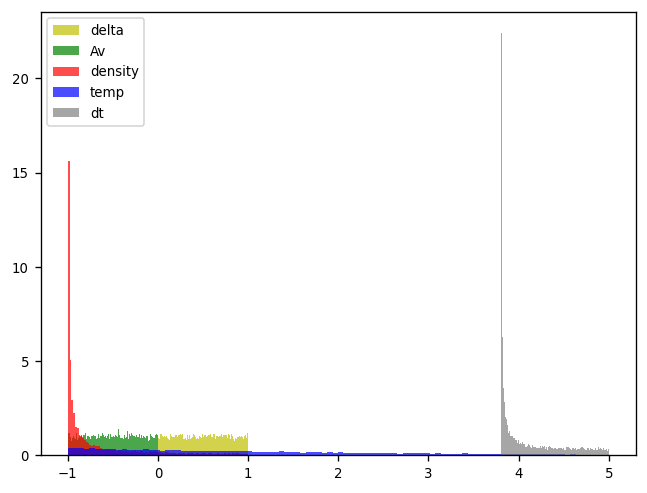

In [4]:
nsamples = 1.e4
nbins = 100

dens_samples = genSamples(ρ_min, ρ_max, nstep, nsamples, fdens)
temp_samples = genSamples(T_min, T_max, nstep, nsamples, ftemp)
delt_samples = genSamples(δ_min, δ_max, nstep, nsamples, fdelta)
Av_samples = genSamples(Av_min, Av_max, nstep, nsamples, fAv)
dt_samples = genSamples(dt_min, dt_max, nstep, nsamples, fdt)


plt.hist(delt_samples,bins=nbins, density=True, color='y', alpha=0.7, label = 'delta')
plt.hist(Av_samples,bins=nbins, density=True, color='g', alpha=0.7, label = 'Av')
plt.hist(dens_samples,bins=nbins, density=True, color='r', alpha=0.7, label = 'density')
plt.hist(temp_samples,bins=nbins, density=True, color='b', alpha=0.7, label = 'temp')
plt.hist(dt_samples,bins=nbins, density=True, color='grey', alpha=0.7, label = 'dt')

plt.legend(loc = 'upper left')
plt.show()

In [5]:
ρ_i  = 1.13E+05
T_i  = 2500
δ_i  = 1.e-1
Av_i = -np.log(1.e-3)

ρ, T, δ, Av = next_input(ρ_i, T_i, δ_i, Av_i)
print('')
ρ2, T2, δ2, Av2 = next_input(ρ, T, δ, Av)
print('')
ρ3, T3, δ3, Av3 = next_input(ρ2, T2, δ2, Av2)
print('')
ρ4, T4, δ4, Av4 = next_input(ρ3, T3, δ3, Av3)

print('')
print('density',ρ_i, ρ, ρ2, ρ3, ρ4)
print('temp   ',T_i, T, T2, T3, T4)
print('delta  ',δ_i, δ, δ2, δ3, δ4)
print('Av     ',Av_i, Av, Av2, Av3, Av4)


[-0.97887971]
[-0.40566446]
[0.08643952]
[-0.4552807]

[-0.09037534]
[3.30723963]
[0.19278513]
[-0.45821485]

[0.8822496]
[-0.62766066]
[0.56151672]
[-0.15361106]

[-0.99579886]
[0.15776157]
[0.03962608]
[-0.59797837]

density 113000.0 [2386.59278786] [2170.90364731] [4086.18252799] [17.16661798]
temp    2500 [1485.83885042] [6399.86398736] [2382.92114589] [2758.85452774]
delta   0.1 [0.10864395] [0.12958889] [0.20235522] [0.21037376]
Av      6.907755278982137 [3.76278763] [2.03862245] [1.72546749] [0.69367526]


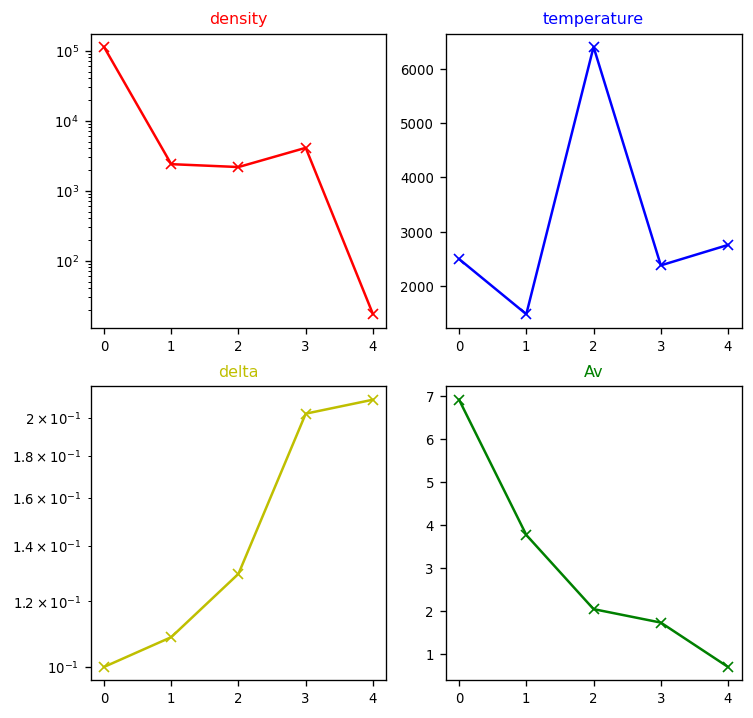

In [6]:
fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,1]},figsize=(7, 7))
ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]
x = [0,1,2,3,4]

ax1.plot(x,np.array([ρ_i, ρ[0], ρ2[0], ρ3[0], ρ4[0]]), 'x-',c='r')
ax2.plot(np.array([T_i, T[0], T2[0], T3[0], T4[0]]), 'x-', c='b')
ax3.plot(np.array([δ_i, δ[0], δ2[0], δ3[0], δ4[0]]), 'x-', c = 'y')
ax4.plot(np.array([Av_i, Av[0], Av2[0], Av3[0], Av4[0]]), 'x-', c= 'g')

ax1.set_title('density', color='r')
ax2.set_title('temperature', color='b')
ax3.set_title('delta', color = 'y')
ax4.set_title('Av', color = 'g')

ax1.set_yscale('log')
ax3.set_yscale('log')



In [7]:
import datetime as dt
from time import time



datum = dt.datetime.now()

print(datum)

# with open(str(dt.datetime.date)+'.out', 'w') as f:
#     f.write('hallo world')

2023-07-21 12:26:27.254221


In [8]:
# elke run eigen map, uniek, date ofzo
# checken op andere computer dat wanneer ge random seeds maakt, dat de random getallen effectief anders zijn
# nu enkel variaties van variabelen, begin met een gekozen input
# starten van de chemie waar ge mee eindigd --> paden in de fysiochemische ruimte
# eind abundantie terug meegeven, niet initialiseren

In [9]:
import src.rates        as rates

chemtype = 'C'

## set initial conditions
n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code

ρi  = 1.13E+05
Ti  = 2500
δi  = 1.e-1
Avi = -np.log(1.e-3)
input = [ρi,Ti,δi,Avi]

Δt =  10**genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec

nf = solve_dg(input, Δt, rate, n, nshield_i, nconsv_tot)
    

---------------------------------------
Input:
[density, temperature, delta, Av], dt:
[113000.0, 2500, 0.1, 6.907755278982137] 6315.37

 >> Solving ODE for Δt = 6315.37 yr...
The solver successfully reached the end of the integration interval.
DONE! In 3.98 seconds.

>> Saving output...
DONE! Output found in ../out/2023-07-21 12:26:25.708272
---------------------------------------


In [10]:

path = '/STER/silkem/ChemTorch/out/2023-07-21 12:26:25.708272/'

print(np.load(path+'input.npy'))

[1.13000000e+05 2.50000000e+03 1.00000000e-01 6.90775528e+00
 8.46907634e+04]
